# Spectral Residual Saliency

Code below implement Spectral Residual Saliency algorithm to generate a saliency map

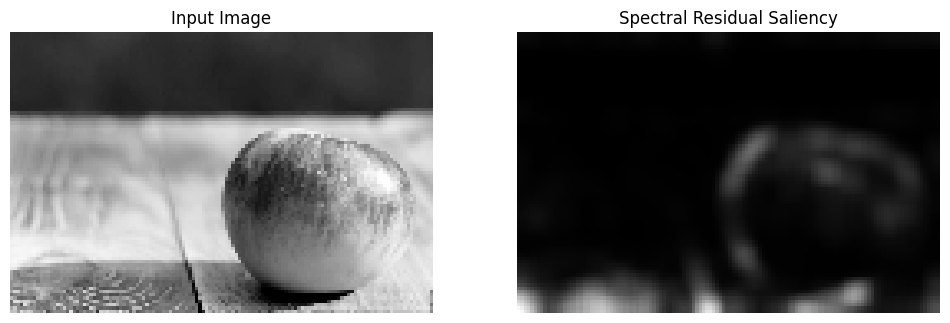

In [ ]:
# Spectral Residual Saliency in Jupyter Notebook

import numpy as np
import cv2
import matplotlib.pyplot as plt

# ------------------------
# Parameters
# ------------------------
WIDTH = 128  # ảnh resize width, ảnh hưởng lớn đến kết quả

# ------------------------
# Load and Resize Image
# ------------------------
img = cv2.imread('images/apple.jpg', 0)  # load grayscale
height, width = img.shape
new_height = int(WIDTH * height / width)
img_resized = cv2.resize(img, (WIDTH, new_height))

# ------------------------
# Compute Fourier Transform
# ------------------------
c = cv2.dft(np.float32(img_resized), flags=cv2.DFT_COMPLEX_OUTPUT)

# Magnitude spectrum
mag = np.sqrt(c[:,:,0]**2 + c[:,:,1]**2)

# Spectral Residual
log_mag = np.log(mag + 1e-8)  # avoid log(0)
avg_log_mag = cv2.boxFilter(log_mag, -1, (3,3))
spectral_residual = np.exp(log_mag - avg_log_mag)

# Apply spectral residual to original complex
c[:,:,0] = c[:,:,0] * spectral_residual / (mag + 1e-8)
c[:,:,1] = c[:,:,1] * spectral_residual / (mag + 1e-8)

# Inverse Fourier Transform
c_inverse = cv2.dft(c, flags=(cv2.DFT_INVERSE | cv2.DFT_SCALE))
saliency_map = c_inverse[:,:,0]**2 + c_inverse[:,:,1]**2

# Gaussian smoothing and normalization
saliency_map = cv2.GaussianBlur(saliency_map, (9,9), 3)
saliency_map = cv2.normalize(saliency_map, None, 0., 1., cv2.NORM_MINMAX)
# ------------------------
# Display
# ------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_resized, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(saliency_map, cmap='gray')
plt.title('Spectral Residual Saliency')
plt.axis('off')
plt.show()

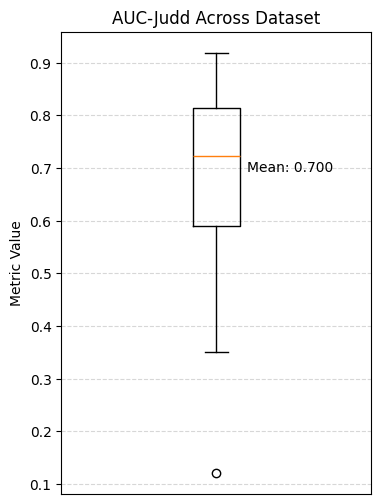

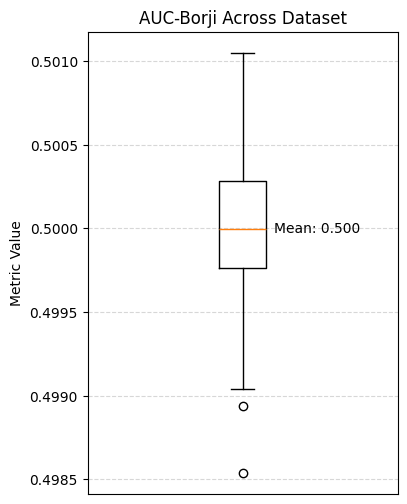

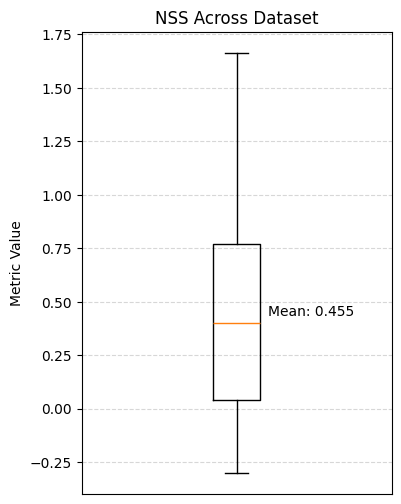

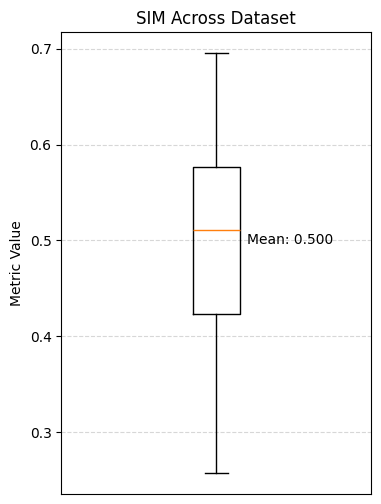

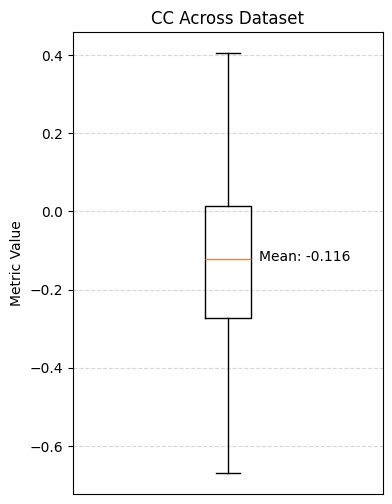

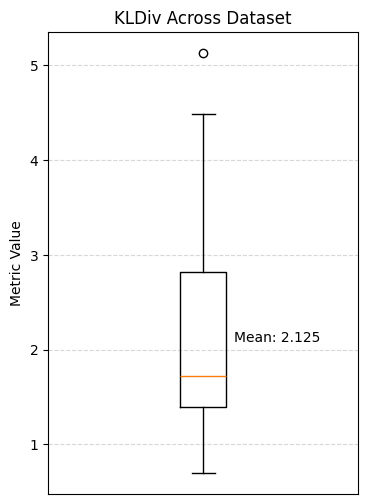

In [19]:
import numpy as np
import cv2
from sklearn.metrics import roc_curve, auc
import os
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Metric functions
# =========================

def auc_judd(saliency, fixation):
    sal = saliency.flatten()
    fix = fixation.flatten()
    fpr, tpr, _ = roc_curve(fix, sal)
    return auc(fpr, tpr)

def auc_borji(saliency, fixation, n_random=100):
    sal = saliency.flatten()
    fix = fixation.flatten()
    N_fix = fix.sum()
    N_total = len(fix)
    aucs = []
    for _ in range(n_random):
        random_fix = np.zeros_like(fix)
        idx = np.random.choice(N_total, int(N_fix), replace=False)
        random_fix[idx] = 1
        fpr, tpr, _ = roc_curve(random_fix, sal)
        aucs.append(auc(fpr, tpr))
    return np.mean(aucs)

def nss(saliency, fixation):
    S = (saliency - saliency.mean()) / (saliency.std() + 1e-8)
    return S[fixation==1].mean()

def sim(saliency, gt):
    sal = saliency / (saliency.sum() + 1e-8)
    gt = gt / (gt.sum() + 1e-8)
    return np.sum(np.minimum(sal, gt))

def cc(saliency, gt):
    a = saliency - saliency.mean()
    b = gt - gt.mean()
    return np.sum(a*b) / (np.sqrt(np.sum(a*a)*np.sum(b*b)) + 1e-8)

def kldiv(saliency, gt):
    sal = saliency / (saliency.sum() + 1e-8)
    gt = gt / (gt.sum() + 1e-8)
    return np.sum(gt * np.log((gt + 1e-8) / (sal + 1e-8)))



# =========================
# Evaluation
# =========================
# root_dir = r"D:\Python_Projects\SpectralResidualSaliency\benchmark_dataset\testSet"

folder_path = r"D:\Python_Projects\SpectralResidualSaliency\benchmark_dataset\testSet\Action"

aucj_list, aucb_list, nss_list, sim_list, cc_list, kl_list = [], [], [], [], [], []

# for folder_name in os.listdir(root_dir):
#     folder_path = os.path.join(root_dir, folder_name)
#     if not os.path.isdir(folder_path):
#         continue
    
output_folder = os.path.join(folder_path, "Output")
    
for file_name in os.listdir(folder_path):
    if not file_name.lower().endswith(".jpg"):
        continue
    
    img_path = os.path.join(folder_path, file_name)
    saliency_name = file_name.replace(".jpg", "_SaliencyMap.jpg")
    saliency_path = os.path.join(output_folder, saliency_name)
    
    if not os.path.exists(saliency_path):
        print(f"No saliency map for {file_name}")
        continue
    
    saliency_map = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE)
    gt_map = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_map = gt_map / 255.0
    saliency_map = saliency_map / 255.0
    
    fixation_map = (gt_map > 0.5).astype(np.uint8)

    fixation_map_resized = cv2.resize(fixation_map, (saliency_map.shape[1], saliency_map.shape[0]), interpolation=cv2.INTER_NEAREST)
    gt_resized = cv2.resize(gt_map, (saliency_map.shape[1], saliency_map.shape[0]), interpolation=cv2.INTER_LINEAR)

    sal_density = cv2.GaussianBlur(saliency_map, (9,9), 4)
    sal_density = sal_density / (sal_density.sum() + 1e-8)
    gt_density = cv2.GaussianBlur(gt_map, (9,9), 4)
    gt_density = gt_density / (gt_density.sum() + 1e-8)

    aucj_list.append(auc_judd(saliency_map, fixation_map_resized))
    aucb_list.append(auc_borji(saliency_map, fixation_map_resized))
    nss_list.append(nss(saliency_map, fixation_map_resized))
    sim_list.append(sim(sal_density, gt_resized))
    cc_list.append(cc(sal_density, gt_resized))
    kl_list.append(kldiv(sal_density, gt_resized))

metrics = {
    'AUC-Judd': aucj_list,
    'AUC-Borji': aucb_list,
    'NSS': nss_list,
    'SIM': sim_list,
    'CC': cc_list,
    'KLDiv': kl_list
}

for name, values in metrics.items():
    plt.figure(figsize=(4,6))
    plt.boxplot(values)
    mean_val = np.mean(values)
    plt.title(f"{name} Across Dataset")
    plt.ylabel("Metric Value")
    plt.xticks([])
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.text(1.1, mean_val, f"Mean: {mean_val:.3f}", verticalalignment='center', color='Black')
    
    plt.show()



# Boolean Map Concept Saliency

In [3]:
# BMS Saliency in Jupyter Notebook
# Original code by Frank Liu - modified for notebook use

# Imports
import os
import timeit
import cv2
import numpy as np
from skimage.color import gray2rgb, rgb2lab
from skimage.io import imread, imsave
from skimage.transform import rescale
import matplotlib.pyplot as plt

N_THRESHOLDS = 10

# ------------------------
# Boolean Map Activation
# ------------------------
def activate_boolean_map(bool_map):
    """
    Performs activation on a single boolean map.
    """
    activation = np.array(bool_map, dtype=np.uint8)
    mask_shape = (bool_map.shape[0] + 2, bool_map.shape[1] + 2)
    ffill_mask = np.zeros(mask_shape, dtype=np.uint8)

    # top and bottom rows
    for i in range(0, activation.shape[0]):
        for j in [0, activation.shape[1] - 1]:
            if activation[i,j]:
                cv2.floodFill(activation, ffill_mask, (j, i), 0)

    # left and right columns
    for i in [0, activation.shape[0] - 1]:
        for j in range(0, activation.shape[1]):
            if activation[i,j]:
                cv2.floodFill(activation, ffill_mask, (j, i), 0)

    return activation

# ------------------------
# Compute Saliency
# ------------------------
def compute_saliency(img):
    """
    Computes Boolean Map Saliency (BMS).
    """
    img_lab = rgb2lab(img)
    img_lab -= img_lab.min()
    img_lab /= img_lab.max()
    thresholds = np.arange(0, 1, 1.0 / N_THRESHOLDS)[1:]

    # compute boolean maps
    bool_maps = []
    for thresh in thresholds:
        img_lab_T = img_lab.transpose(2, 0, 1)
        img_thresh = (img_lab_T > thresh)
        bool_maps.extend(list(img_thresh))

    # compute mean attention map
    attn_map = np.zeros(img_lab.shape[:2], dtype=np.float32)
    for bool_map in bool_maps:
        attn_map += activate_boolean_map(bool_map)
    attn_map /= N_THRESHOLDS

    # gaussian smoothing
    attn_map = cv2.GaussianBlur(attn_map, (0, 0), 3)

    # perform normalization
    norm = np.sqrt((attn_map**2).sum())
    attn_map /= (norm + 1e-8)  # avoid division by zero
    attn_map /= attn_map.max() / 255

    return attn_map.astype(np.uint8)

# ------------------------
# Helper: Load & Resize Image
# ------------------------
def load_image(img_path, max_dim=320):
    img = imread(img_path)
    if img.ndim == 2:
        img = gray2rgb(img)
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    upper_dim = max(img.shape[:2])
    if upper_dim > max_dim:
        img = rescale(
            img, 
            max_dim/float(upper_dim), 
            order=3, 
            anti_aliasing=True, 
            channel_axis=-1  # <--- sửa ở đây
        )
        img = (img * 255).astype(np.uint8)
    return img


# ------------------------
# Run Saliency and Display
# ------------------------
def run_saliency(img_path, max_dim=320, save_output=True):
    img = load_image(img_path, max_dim)
    
    # plt.figure(figsize=(10,5))
    # plt.subplot(1,2,1)
    # plt.imshow(img)
    # plt.title("Input Image")
    # plt.axis('off')
    
    # start = timeit.default_timer()
    sal_map = compute_saliency(img)
    # runtime = timeit.default_timer() - start
    # print(f"Saliency computed in {runtime:.3f} seconds.")
    
    # plt.subplot(1,2,2)
    # plt.imshow(sal_map, cmap='gray')
    # plt.title("Saliency Map")
    # plt.axis('off')
    # plt.show()
    
    # if save_output:
    #     fname, ext = os.path.splitext(img_path)
    #     out_path = fname + "_saliency" + ext
    #     imsave(out_path, sal_map)
    #     print(f"Saliency map saved to {out_path}")

    return sal_map

sal_map = run_saliency('images/apple.jpg', max_dim=320)

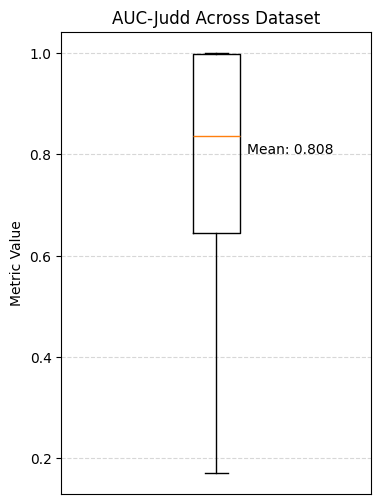

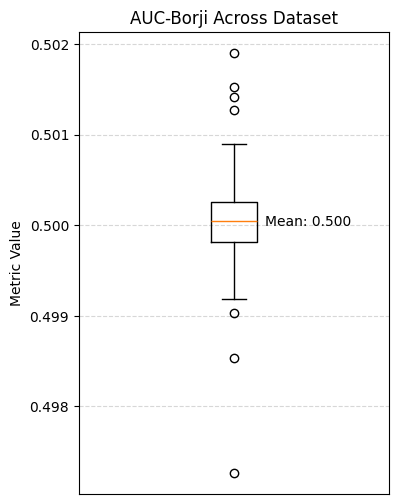

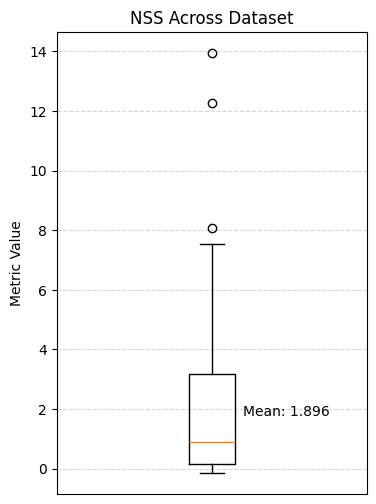

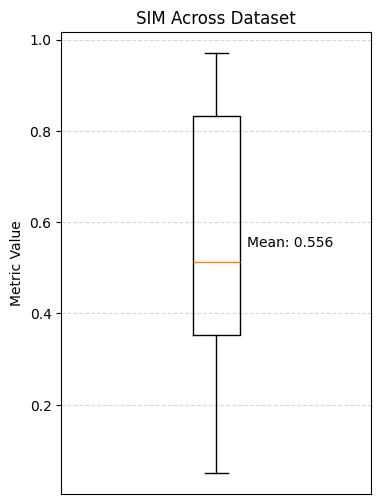

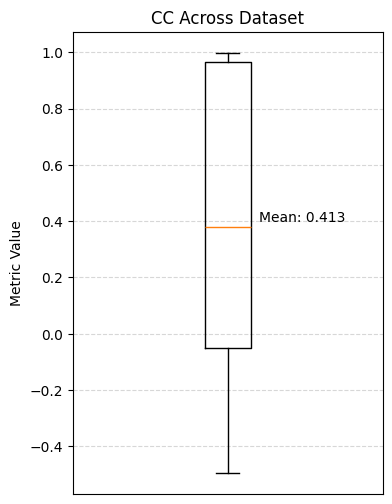

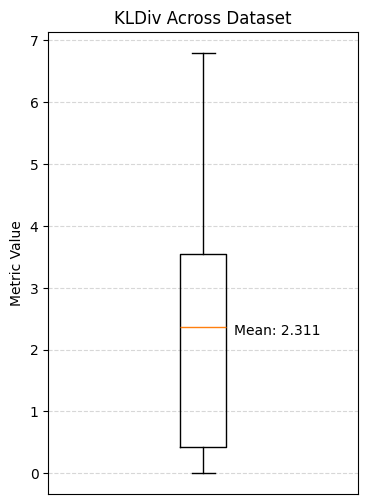

In [ ]:
import os
import timeit
import cv2
import numpy as np
from skimage.color import gray2rgb, rgb2lab
from skimage.io import imread, imsave
from skimage.transform import rescale
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# =========================
# Metric functions
# =========================
def auc_judd(saliency, fixation):
    sal = saliency.flatten()
    fix = fixation.flatten()
    fpr, tpr, _ = roc_curve(fix, sal)
    return auc(fpr, tpr)

def auc_borji(saliency, fixation, n_random=100):
    sal = saliency.flatten()
    fix = fixation.flatten()
    N_fix = fix.sum()
    N_total = len(fix)
    aucs = []
    for _ in range(n_random):
        random_fix = np.zeros_like(fix)
        idx = np.random.choice(N_total, int(N_fix), replace=False)
        random_fix[idx] = 1
        fpr, tpr, _ = roc_curve(random_fix, sal)
        aucs.append(auc(fpr, tpr))
    return np.mean(aucs)

def nss(saliency, fixation):
    S = (saliency - saliency.mean()) / (saliency.std() + 1e-8)
    return S[fixation==1].mean()

def sim(saliency, gt):
    sal = saliency / (saliency.sum() + 1e-8)
    gt = gt / (gt.sum() + 1e-8)
    return np.sum(np.minimum(sal, gt))

def cc(saliency, gt):
    a = saliency - saliency.mean()
    b = gt - gt.mean()
    return np.sum(a*b) / (np.sqrt(np.sum(a*a)*np.sum(b*b)) + 1e-8)

def kldiv(saliency, gt):
    sal = saliency / (saliency.sum() + 1e-8)
    gt = gt / (gt.sum() + 1e-8)
    return np.sum(gt * np.log((gt + 1e-8) / (sal + 1e-8)))

# =========================
# Run Evaluation on Folder
# =========================
folder_path = r"D:\Python_Projects\SpectralResidualSaliency\benchmark_dataset\testSet\Art"
output_folder = os.path.join(folder_path, "Output")
os.makedirs(output_folder, exist_ok=True)

aucj_list, aucb_list, nss_list, sim_list, cc_list, kl_list = [], [], [], [], [], []

for file_name in os.listdir(folder_path):
    if not file_name.lower().endswith(".jpg"):
        continue

    img_path = os.path.join(folder_path, file_name)
    saliency_map = run_saliency(img_path)
    imsave(os.path.join(output_folder, file_name.replace(".jpg","_SaliencyMap.jpg")), saliency_map)

    gt_map = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    fixation_map = (gt_map > 0.5).astype(np.uint8)
    
    fixation_map_resized = cv2.resize(fixation_map, (saliency_map.shape[1], saliency_map.shape[0]), interpolation=cv2.INTER_NEAREST)
    gt_resized = cv2.resize(gt_map, (saliency_map.shape[1], saliency_map.shape[0]), interpolation=cv2.INTER_LINEAR)

    sal_density = cv2.GaussianBlur(saliency_map.astype(np.float32)/255, (9,9), 4)
    sal_density /= (sal_density.sum() + 1e-8)
    gt_density = cv2.GaussianBlur(gt_resized, (9,9), 4)
    gt_density /= (gt_density.sum() + 1e-8)

    aucj_list.append(auc_judd(saliency_map/255, fixation_map_resized))
    aucb_list.append(auc_borji(saliency_map/255, fixation_map_resized))
    nss_list.append(nss(saliency_map/255, fixation_map_resized))
    sim_list.append(sim(sal_density, gt_density))
    cc_list.append(cc(sal_density, gt_density))
    kl_list.append(kldiv(sal_density, gt_density))

metrics = {
    'AUC-Judd': aucj_list,
    'AUC-Borji': aucb_list,
    'NSS': nss_list,
    'SIM': sim_list,
    'CC': cc_list,
    'KLDiv': kl_list
}

for name, values in metrics.items():
    plt.figure(figsize=(4,6))
    plt.boxplot(values,showfliers=False)
    mean_val = np.mean(values)
    plt.title(f"{name} Across Dataset")
    plt.ylabel("Metric Value")
    plt.xticks([])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.text(1.1, mean_val, f"Mean: {mean_val:.3f}", verticalalignment='center', color='Black')
    plt.show()